In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
project_path = r'~\Data'

users = pd.read_csv(rf'{project_path}\users.csv')
movies = pd.read_csv(rf'{project_path}\movies.tsv', delimiter='\t')
ratings = pd.read_csv(rf'{project_path}\ratings.csv')

# Some basic EDA

In [3]:
# number of ratings per user
ratings.groupby('userID').agg({'movieID':'count'}).reset_index().movieID.quantile([0.05,0.5,0.95])

0.05     1.0
0.50     3.0
0.95    77.0
Name: movieID, dtype: float64

In [4]:
# fraction of users with 5 ratings
ratings[ratings.rating==5].userID.nunique() / len(users)

0.49851253718657035

In [5]:
# fraction of users with high ratings (>= 4)
ratings[ratings.rating.isin([4,5])].userID.nunique() / len(users)

0.7662558436039099

In [6]:
# number of high ratings per user
ratings[ratings.rating.isin([4,5])].groupby('userID').agg({'movieID':'count'}).reset_index().movieID.quantile([0.05,0.5,0.95])

0.05     1.0
0.50     3.0
0.95    53.0
Name: movieID, dtype: float64

In [7]:
# fraction of users with low ratings (<= 2)
ratings[ratings.rating.isin([1,2])].userID.nunique() / len(users)

0.5142371440713982

In [8]:
# number of low ratings per user
ratings[ratings.rating.isin([1,2])].groupby('userID').agg({'movieID':'count'}).reset_index().movieID.quantile([0.05,0.5,0.95])

0.05     1.0
0.50     2.0
0.95    17.0
Name: movieID, dtype: float64

# Surprise implementation
Note that crossvalidation as implemented by the surprise library does something sneaky: when the test set contains users or movies not in the training set, it uses a "default prediction" equal to the global mean of all ratings in the dataset, since the training set has never seen that particular user or movie. This is then incorporated into the accuracy measure of choice (RMSE or MAE (mean absolute error)).

In [9]:
from surprise import Reader, Dataset
from surprise import NMF
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

In [10]:
# ratings get clipped from 1 to 5
reader = Reader(rating_scale=(1.0,5.0))

In [11]:
# ratings must have 3 cols: users, items, ratings (in that order)
data = Dataset.load_from_df(ratings, reader)

## Cross-validation with k = 15

In [12]:
algo = NMF() # default n_factors = 15
results = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)
results

{'test_rmse': array([1.02399549, 1.01239681, 1.00319654, 1.0105575 , 1.01594149]),
 'fit_time': (3.6132943630218506,
  3.5480494499206543,
  3.3160624504089355,
  3.3250372409820557,
  2.9878628253936768),
 'test_time': (0.06966471672058105,
  0.07973957061767578,
  0.035352230072021484,
  0.1253654956817627,
  0.0334925651550293)}

In [13]:
# get the mean crossvalidation RMSE
# result: RMSE = 1.02. Interpretation: predictions are about 1 "star" off from the true rating
pd.DataFrame.from_dict(results).mean(axis=0)['test_rmse']

1.013217568543143

In [14]:
trainset, testset = train_test_split(data, test_size=.25)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

In [15]:
# Compute RMSE on the test set
accuracy.rmse(predictions)

RMSE: 1.0239


1.023883888208289

In [16]:
# run the model on the training set and get the RMSE (which should be lower than on the test set)
accuracy.rmse(algo.test(trainset.build_testset()))

RMSE: 0.5913


0.5913207333255329

In [17]:
# get the predictions on the training set (to compare to the actual ratings) and the test set
train_preds = pd.DataFrame([(x.uid, x.iid, x.est, x.r_ui) for x in algo.test(trainset.build_testset())], columns=['userID','movieID', 'prediction', 'actual_rating'])
test_preds = pd.DataFrame([(x.uid, x.iid, x.est, x.r_ui) for x in algo.test(testset)], columns=['userID','movieID', 'prediction', 'actual_rating'])

In [18]:
# summary of predicted ratings in training set (min, max, mean, 5%, median, 95%)
{'training set (min, max, mean, (5th percentile, median, 95th percentile))': [train_preds.prediction.min(), train_preds.prediction.max(), train_preds.prediction.mean(), np.quantile(train_preds.prediction, [0.05,0.5,0.95])],
 'test set (min, max, mean, (5th percentile, median, 95th percentile))': [test_preds.prediction.min(), test_preds.prediction.max(), test_preds.prediction.mean(), np.quantile(test_preds.prediction, [0.05,0.5,0.95])]}

{'training set (min, max, mean, (5th percentile, median, 95th percentile))': [1.0,
  5.0,
  3.577074252037251,
  array([1.99241222, 3.70340921, 4.8582949 ])],
 'test set (min, max, mean, (5th percentile, median, 95th percentile))': [1.0,
  5.0,
  3.490849305518112,
  array([1.96387209, 3.57908497, 4.69721132])]}

## Build a model on the *full* dataset to get predictions on all pairs
Now that the model performance has been assessed, we can re-train on the full dataset. If only the training set were used in the model, then we wouldn't be able to get predictions on users or movies not in the training set.

In [19]:
train_set = Dataset.load_from_df(ratings, reader).build_full_trainset()

In [20]:
algo = NMF()
algo.fit(train_set)

In [21]:
# get predictions for *every* user/movie combo. These will be also compared to the actual ratings
all_pairs = [(x, y, 0) for x in users.userID for y in movies.movieID]
df_all_pairs = pd.DataFrame(all_pairs, columns=['userID','movieID','rating'])

In [22]:
[len(df_all_pairs), len(movies) * len(users)]

[3447145, 3447145]

In [23]:
all_pairs[1:3]

[(4, 2, 0), (4, 3, 0)]

In [24]:
# getting predictions for ALL user/movie combos
# took 40 seconds on 3.4 million rows
all_preds = algo.test(all_pairs)

In [25]:
all_preds = pd.DataFrame([{'userID':y.uid, 'movieID':y.iid, 'predicted_rating':y.est} for y in all_preds])

In [26]:
nmf_predictions = all_preds.merge(ratings, on=['userID','movieID'], how='left')

In [27]:
# ratings for missing values look appropriate (not close to 0; see section "Issues with scikitlearn's NMF" below)
nmf_predictions[nmf_predictions.movieID==1].head(20)

,userID,movieID,predicted_rating,rating
0,4,1,3.992189,NaN
1465,5,1,4.256339,NaN
2930,6,1,4.113705,NaN
4395,15,1,4.928950,NaN
5860,17,1,3.154745,NaN
7325,18,1,4.915176,NaN
8790,19,1,4.258238,NaN
10255,22,1,4.607505,NaN
11720,23,1,2.309856,NaN
13185,24,1,3.585239,NaN


# Issues with scikitlearn's NMF

It turns out NMF in scikitlearn cannot handle missing values in the factorized matrix. It is common [1] to populate these values with 0, but then the task of imputing those values (as opposed to getting values close to 0) is only possible if the optimization ignores those zeroes  are ignored when calculating the reconstruction error (Frobenius norm). Unfortunately, scikitlearn does not do this. There is a pull request on github from 2017 to update NMF in scikitlearn to handle missing values appropriately [2], but it was deemed "out of scope of scikit-learn".

The surprise library [3] correctly fits using only the ratings available during training, avoiding the matrix multiplication used in scikitlearn to calculate the Frobenius norm.

The analysis below shows how scikitlearn calculates values close to 0 for missing values.

[1] V. Tan and C. Févotte, “Automatic relevance determination in nonnegative matrix factorization with the β-divergence,” IEEE Trans. Pattern Analysis Machine Intelligence, vol. 35, no. 7, pp. 1592–1602, 2013.
Google Scholar

[2] https://github.com/scikit-learn/scikit-learn/pull/8474

[3] http://surpriselib.com/

In [28]:
from sklearn.decomposition import NMF 

In [29]:
ratings_pivot = ratings.pivot(index = 'userID', columns ='movieID', values = 'rating').fillna(0)

In [30]:
# note the 0s we filled in for missing values
ratings_pivot

movieID,1,2,3,4,5,6,7,8,9,12,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
userID,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
model = NMF(n_components=10, init='random', random_state=0)

# X = W.dot(H)
W = model.fit_transform(ratings_pivot)
H = model.components_

In [32]:
# the Frobenius norm
model.reconstruction_err_

530.3398804488565

In [33]:
df_reconstructed_ratings = pd.DataFrame(np.dot(W, H))

# get the userID column from ratings_pivot, then re-order the columns to put userID first
df_reconstructed_ratings['userID'] = list(ratings_pivot.reset_index().userID)
df_reconstructed_ratings = df_reconstructed_ratings[['userID', *[x for x in df_reconstructed_ratings.columns if x != 'userID']]]

# replace the column names with the movie IDs. Using ratings_pivot's order rather than movies
movie_ids = list(ratings_pivot.reset_index().columns[1:])
col_indices = list(df_reconstructed_ratings.columns[1:])
df_reconstructed_ratings.rename(columns=dict(zip(col_indices, movie_ids)), inplace=True)

In [34]:
# convert back to the tall, skinny ratings dataframe
df_final_ratings = df_reconstructed_ratings.melt(id_vars=['userID'], var_name='movieID', value_name='predicted_rating')
df_final_ratings = df_final_ratings.merge(ratings, on=['userID','movieID'], how='left')

# missing ratings are close to 0 -- not what we want
df_final_ratings[df_final_ratings['rating'].isna()].head(20)

,userID,movieID,predicted_rating,rating
0,4,1,0.098850,NaN
1,5,1,0.039986,NaN
2,6,1,0.009789,NaN
3,15,1,0.274227,NaN
4,17,1,0.045453,NaN
5,18,1,0.054255,NaN
6,19,1,0.003077,NaN
7,22,1,0.000000,NaN
8,23,1,0.014034,NaN
9,24,1,0.018815,NaN


# Cosine Similarity
Cosine similarity of movies will be calculated using the title, genres, and tags from the combined Netflix dataset (our project dataset) and MovieLens dataset

## Read in the MovieLens movies and tags, and fold into the project data
MovieLens dataset: https://grouplens.org/datasets/movielens/20m/

In [35]:
# movielens movies
ml_movies = pd.read_csv(rf'{project_path}\movielens_20M_movies.csv')
ml_movies.rename(columns={'movieId': 'movieID'}, inplace=True) 

# remove year from movie titles
ml_movies['title'] = ml_movies['title'].str[:-6] 

In [36]:
ml_movies.head()

,movieID,title,genres
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji,Adventure|Children|Fantasy
2,3,Grumpier Old Men,Comedy|Romance
3,4,Waiting to Exhale,Comedy|Drama|Romance
4,5,Father of the Bride Part II,Comedy


In [37]:
movies_merged = movies.merge(ml_movies, on="movieID", how='left')
movies_merged.head()

,movieID,name,year,genre1,genre2,genre3,title,genres
0,1,Toy Story,1995,Animation,Children's,Comedy,Toy Story,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji,1995,Adventure,Children's,Fantasy,Jumanji,Adventure|Children|Fantasy
2,3,Grumpier Old Men,1995,Comedy,Romance,NaN,Grumpier Old Men,Comedy|Romance
3,4,Waiting to Exhale,1995,Comedy,Drama,NaN,Waiting to Exhale,Comedy|Drama|Romance
4,5,Father of the Bride Part II,1995,Comedy,NaN,NaN,Father of the Bride Part II,Comedy


In [38]:
# visual inspection of mis-matched movie titles
# it appears all movie titles match up, except for 
pd.set_option('display.max_rows', None)
movies_merged.loc[movies_merged['title'] != movies_merged['name'], ['movieID','name','title','genres']].head(200)

,movieID,name,title,genres
16,32,Twelve Monkeys,Twelve Monkeys (a.k.a. 12 Monkeys),Mystery|Sci-Fi|Thriller
23,47,Seven (Se7en),Seven (a.k.a. Se7en),Mystery|Thriller
27,58,"Postino, Il (The Postman)","Postman, The (Postino, Il)",Comedy|Drama|Romance
61,231,Dumb & Dumber,Dumb & Dumber (Dumb and Dumber),Adventure|Comedy
62,232,Eat Drink Man Woman,Eat Drink Man Woman (Yin shi nan nu),Comedy|Drama|Romance
73,250,Heavyweights,Heavyweights (Heavy Weights),Children|Comedy
75,253,Interview with the Vampire,Interview with the Vampire: The Vampire Chroni...,Drama|Horror
93,293,"Professional, The (a.k.a. Leon: The Profession...",Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller
97,307,Three Colors: Blue,Three Colors: Blue (Trois couleurs: Bleu),Drama
114,366,Wes Craven's New Nightmare,Wes Craven's New Nightmare (Nightmare on Elm S...,Drama|Horror|Mystery|Thriller


In [39]:
# there are 4 non-matches in the MovieLens dataset
sum(movies_merged.genres.isna())

4

In [40]:
# get the tags
ml_tags = pd.read_csv(rf'{project_path}\movielens_20M_tags.csv')
ml_tags.rename(columns={'userId':'userID','movieId':'movieID'}, inplace=True)
ml_tags = ml_tags.astype({'tag':str})
ml_tags.head()

,userID,movieID,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


### Replace any punctuation in tags, titles, and genres with spaces, and combine altogether

In [41]:
# replace punctuation in tags (a space), movie name (a space), and genres (no space). These will eventually be folded into the tags list
ml_tags.tag = ml_tags.tag.str.replace('[^\w\s]',' ')
movies_merged.name = movies_merged.name.str.replace('[^\w\s]',' ')
movies_merged.genre1 = movies_merged.genre1.str.replace('[^\w\s]','')
movies_merged.genre2 = movies_merged.genre2.str.replace('[^\w\s]','')
movies_merged.genre3 = movies_merged.genre3.str.replace('[^\w\s]','')
movies_merged.genres = movies_merged.genres.str.replace('[^\w\s]',' ')

In [42]:
[movies_merged.genre1.unique(), movies_merged.genre2.unique(), movies_merged.genre3.unique()]

[array(['Animation', 'Adventure', 'Comedy', 'Action', 'Drama', 'Romance',
        'Childrens', 'Crime', 'Documentary', 'Thriller', 'Horror',
        'Western', 'Mystery', 'FilmNoir', 'SciFi', 'Musical', 'War'],
       dtype=object),
 array(['Childrens', 'Romance', 'Drama', nan, 'Crime', 'Horror', 'Comedy',
        'SciFi', 'Thriller', 'Mystery', 'Adventure', 'Fantasy', 'Western',
        'War', 'Animation', 'FilmNoir', 'Musical', 'Documentary'],
       dtype=object),
 array(['Comedy', 'Fantasy', nan, 'Thriller', 'Drama', 'Musical', 'War',
        'Crime', 'SciFi', 'Romance', 'Western', 'Horror', 'Mystery',
        'FilmNoir', 'Childrens', 'Animation'], dtype=object)]

In [43]:
movies_merged.head()

,movieID,name,year,genre1,genre2,genre3,title,genres
0,1,Toy Story,1995,Animation,Childrens,Comedy,Toy Story,Adventure Animation Children Comedy Fantasy
1,2,Jumanji,1995,Adventure,Childrens,Fantasy,Jumanji,Adventure Children Fantasy
2,3,Grumpier Old Men,1995,Comedy,Romance,NaN,Grumpier Old Men,Comedy Romance
3,4,Waiting to Exhale,1995,Comedy,Drama,NaN,Waiting to Exhale,Comedy Drama Romance
4,5,Father of the Bride Part II,1995,Comedy,NaN,NaN,Father of the Bride Part II,Comedy


In [44]:
ml_tags = ml_tags.groupby('movieID').tag.apply(' '.join).reset_index()
ml_tags.head()

,movieID,tag
0,1,Watched computer animation Disney animated fea...
1,2,time travel adapted from book board game child...
2,3,old people that is actually funny sequel fever...
3,4,chick flick revenge characters chick flick cha...
4,5,Diane Keaton family sequel Steve Martin weddin...


In [45]:
movies_merged = movies_merged.merge(ml_tags, on='movieID', how='left')

In [46]:
# merge name, genres, and tags together
movies_merged['tags'] = movies_merged.apply(lambda x: '{} {} {} {} {}'.format(x['name'], x['genre1'], x['genre2'], x['genre3'], x['tag']), axis=1)
movies_merged.head()

,movieID,name,year,genre1,genre2,genre3,title,genres,tag,tags
0,1,Toy Story,1995,Animation,Childrens,Comedy,Toy Story,Adventure Animation Children Comedy Fantasy,Watched computer animation Disney animated fea...,Toy Story Animation Childrens Comedy Watched ...
1,2,Jumanji,1995,Adventure,Childrens,Fantasy,Jumanji,Adventure Children Fantasy,time travel adapted from book board game child...,Jumanji Adventure Childrens Fantasy time trav...
2,3,Grumpier Old Men,1995,Comedy,Romance,NaN,Grumpier Old Men,Comedy Romance,old people that is actually funny sequel fever...,Grumpier Old Men Comedy Romance nan old peopl...
3,4,Waiting to Exhale,1995,Comedy,Drama,NaN,Waiting to Exhale,Comedy Drama Romance,chick flick revenge characters chick flick cha...,Waiting to Exhale Comedy Drama nan chick flic...
4,5,Father of the Bride Part II,1995,Comedy,NaN,NaN,Father of the Bride Part II,Comedy,Diane Keaton family sequel Steve Martin weddin...,Father of the Bride Part II Comedy nan nan Di...


### Vectorize to calculate similarities

In [47]:
# stop_words ignores words like 'the'; 
# min_df says ignore words that show up in fewer than min_df documents
vectorizer = TfidfVectorizer(stop_words='english', min_df=3)
tfidf_matrix = vectorizer.fit_transform(movies_merged['tags'])

In [48]:
def get_similar_movies(vectorizer, movieID):
    # get the index of the movie
    idx = np.where(movies_merged.movieID==movieID)[0][0]
    print('Getting similar movies to ' + movies_merged.iloc[idx]['name'] + '...')
    
    y = cosine_similarity(vectorizer[idx], vectorizer)
    idx_scores = pd.DataFrame([(idx, score) for (idx, score) in enumerate(list(y[0])) if score>0], columns=['idx','score'])
    
    result = pd.concat([movies_merged.iloc[idx_scores.idx].reset_index(), idx_scores], axis=1).sort_values(by='score', ascending=False)
    
    # get rid of transformed columns from movies_merged (except tag), and get the *original* name and genres with punctuation
    result.drop(columns=[x for x in [*movies_merged, 'index','idx'] if x not in ['movieID','tag']], inplace=True)
    result = result.merge(movies, on='movieID', how='left')
    result = result[['movieID','name','year','genre1','genre2','genre3','tag','score']]
    return result

In [49]:
# note that there are fewer rows (1331) than in the full dataset (1465) because we excluded rows with score == 0
get_similar_movies(tfidf_matrix, 1)

Getting similar movies to Toy Story ...


,movieID,name,year,genre1,genre2,genre3,tag,score
0,1,Toy Story,1995,Animation,Children's,Comedy,Watched computer animation Disney animated fea...,1.000000
1,3114,Toy Story 2,1999,Animation,Children's,Comedy,animation humorous Pixar animation cute fancif...,0.948425
2,2355,"Bug's Life, A",1998,Animation,Children's,Comedy,Watched computer animation Disney animated fea...,0.880805
3,2294,Antz,1998,Animation,Children's,NaN,Pixar animation Pixar anti war capitalism dark...,0.532589
4,596,Pinocchio,1940,Animation,Children's,NaN,Disney animated feature puppetry classic disne...,0.478103
5,364,"Lion King, The",1994,Animation,Children's,Musical,coming of age Disney animated feature heredita...,0.298505
6,1688,Anastasia,1997,Animation,Children's,Musical,villain nonexistent or not needed for good sto...,0.294122
7,3615,Dinosaur,2000,Animation,Children's,NaN,Disney animated feature dinosaurs disney compu...,0.290497
8,2085,101 Dalmatians,1961,Animation,Children's,NaN,Disney animated feature remadeAs 101 Dalmation...,0.290278
9,595,Beauty and the Beast,1991,Animation,Children's,Musical,Disney Watched Bechdel Test Fail Disney animat...,0.288184


# Final recommendation algorithm

Combines NMF (collaborative filtering, based on users' ratings from the project dataset) with cosine similarity (content filtering, based on movies' tags (from the MovieLens dataset), which contain things like genre, director, and other descriptors.

Recommendation function returns a list of 5 movies for a given user, assuming that user is in the dataset.

Note that the MovieLens movies file is not needed; only the tags file. It was confirmed that the movie IDs in the project dataset and the MovieLens datasets match (except for formatting differences).

In [1]:
import pandas as pd
from NMF_Cosine_Recommender import NMF_Cosine_Recommender as recommender

project_path = r'C:\Users\jabbe\Documents\SCHOOL\UMass\Fall 2019\STAT 535\Project\Data'
users = pd.read_csv(rf'{project_path}\users.csv')
movies = pd.read_csv(rf'{project_path}\movies.tsv', delimiter='\t')
ratings = pd.read_csv(rf'{project_path}\ratings.csv')
ml_tags = pd.read_csv(rf'{project_path}\movielens_20M_tags.csv')

## Run step-by-step

In [2]:
model = recommender(users, movies, ratings, ml_tags, biased=False)

In [3]:
# creates a combination "tags" column of the title, genres, and tags from MovieLens,
# and replaces punctuation with spaces
model.preprocess_tags()

Preprocessing tags and movie information...Done


In [4]:
# fits a TF-IDF vectorization to the tags from the preprocess_tags step
model.train_cosine_similarity(seed=535)

Cosine similarity training...Done


In [5]:
model.get_similar_movies(movieID=1, number_of_movies=10)

Getting similar movies to Toy Story ...Done


,movieID,name,year,genre1,genre2,genre3,tags,similarity
1,3114,Toy Story 2,1999,Animation,Children's,Comedy,animation humorous Pixar animation cute fancif...,0.948425
2,2355,"Bug's Life, A",1998,Animation,Children's,Comedy,Watched computer animation Disney animated fea...,0.880805
3,2294,Antz,1998,Animation,Children's,NaN,Pixar animation Pixar anti-war capitalism dark...,0.532622
4,596,Pinocchio,1940,Animation,Children's,NaN,Disney animated feature puppetry classic disne...,0.478164
5,364,"Lion King, The",1994,Animation,Children's,Musical,coming of age Disney animated feature heredita...,0.298505
6,1688,Anastasia,1997,Animation,Children's,Musical,villain nonexistent or not needed for good sto...,0.294122
7,3615,Dinosaur,2000,Animation,Children's,NaN,Disney animated feature dinosaurs disney compu...,0.290819
8,2085,101 Dalmatians,1961,Animation,Children's,NaN,Disney animated feature remadeAs:101 Dalmation...,0.290294
9,595,Beauty and the Beast,1991,Animation,Children's,Musical,Disney Watched Bechdel Test:Fail Disney animat...,0.288184
10,2081,"Little Mermaid, The",1989,Animation,Comedy,Musical,Disney Watched adapted from:book Disney animat...,0.276312


In [6]:
model.run_nmf(n_factors=15, run_cross_validation=True, seed=535, verbose=True)

Running cross-validation...Done
Average CV score: 1.0165
Average fit time: 3.6981 seconds
NMF Fitting...Done
Generating all user-movie pairs for predictions...Done
Calculating predictions on all user-movie pairs...Done


In [47]:
model.get_recommendations(userID=37, number_of_recs=20, seed=535, show_user_likes=True)

Getting user's highest rated movies to start from...Done

---------------
Highest-reviewed movies for userID 37:
    userID  movieID                                     name  rating
0       37     3623                   Mission: Impossible 2        5
1       37     1721                                 Titanic        5
2       37     3510                               Frequency        5
3       37     3555                                   U-571        5
4       37     3578                               Gladiator        5
5       37     3753                            Patriot, The        5
6       37     3615                                Dinosaur        4
7       37     3717                      Gone in 60 Seconds        4
8       37     3746  Butterfly (La Lengua de las Mariposas)        4
9       37     3793                                   X-Men        4
10      37     3755                      Perfect Storm, The        4
11      37     1240                         Terminator, The

,movieID,name,year,genres,tags,similar_to,similarity,nmf_prediction,weighted_rating
4,110,Braveheart,1995,Action/Drama/War,drama historical Medieval mel gibson Nudity (T...,"Patriot, The",0.701565,4.742437,3.327126
0,589,Terminator 2: Judgment Day,1991,Action/Sci-Fi/Thriller,dystopia sci-fi time travel android(s)/cyborg(...,"Terminator, The",0.903422,3.482558,3.146219
7,786,Eraser,1996,Action/Thriller,Oscar Nominee action animal attacks Arnold Sch...,"Terminator, The",0.684168,4.107573,2.810272
19,3654,"Guns of Navarone, The",1961,Action/Drama/War,dialogue World War II World War II World War I...,U-571,0.596033,4.095199,2.440875
21,2641,Superman II,1980,Action/Adventure/Sci-Fi,adapted from:comic alter ego Christopher Reeve...,X-Men,0.586295,4.101303,2.404574
31,1272,Patton,1970,Drama/War,WWII biography true story US history World War...,U-571,0.525239,4.425239,2.324308
5,1286,Somewhere in Time,1980,Drama/Romance,time travel Location:Macinac Island time trave...,Frequency,0.693946,3.343376,2.320121
2,2640,Superman,1978,Action/Adventure/Sci-Fi,adapted from:comic alter ego super hero no mor...,X-Men,0.727378,3.151486,2.292320
34,1250,"Bridge on the River Kwai, The",1957,Drama/War,adapted from:book Bechdel Test:Fail cult of ma...,U-571,0.514111,4.435623,2.280403
3,1270,Back to the Future,1985,Comedy/Sci-Fi,Steven Spielberg time travel rock and roll tim...,Frequency,0.713025,3.128370,2.230605


## Or, run all at once

In [8]:
model2 = recommender(users, movies, ratings, ml_tags, biased=False)
model2.train(n_factors=15, run_cross_validation=False, seed=535)

Preprocessing tags and movie information...Done
Cosine similarity training...Done
NMF Fitting...Done
Generating all user-movie pairs for predictions...Done
Calculating predictions on all user-movie pairs...Done


In [9]:
# get ALL similarities for this movie by specifying number_of_movies=None
model2.get_similar_movies(movieID=1, number_of_movies=None)

Getting similar movies to Toy Story ...Done


,movieID,name,year,genre1,genre2,genre3,tags,similarity
1,3114,Toy Story 2,1999,Animation,Children's,Comedy,animation humorous Pixar animation cute fancif...,0.948425
2,2355,"Bug's Life, A",1998,Animation,Children's,Comedy,Watched computer animation Disney animated fea...,0.880805
3,2294,Antz,1998,Animation,Children's,NaN,Pixar animation Pixar anti-war capitalism dark...,0.532622
4,596,Pinocchio,1940,Animation,Children's,NaN,Disney animated feature puppetry classic disne...,0.478164
5,364,"Lion King, The",1994,Animation,Children's,Musical,coming of age Disney animated feature heredita...,0.298505
...,...,...,...,...,...,...,...,...
1326,3262,Twin Peaks: Fire Walk with Me,1992,Drama,Mystery,NaN,David Lynch drugs surreal murder Nudity (Tople...,0.000149
1327,1835,City of Angels,1998,Romance,NaN,NaN,Meg Ryan Nicolas Cage stupid character mawkish...,0.000127
1328,230,Dolores Claiborne,1994,Drama,Thriller,NaN,child abuse drama BGAB LRC housekeeper incest ...,0.000122
1329,3505,No Way Out,1987,Thriller,NaN,NaN,adultery alter ego Bechdel Test:Fail espionage...,0.000121


In [48]:
model2.get_recommendations(userID=37, number_of_recs=20, seed=535)

Getting user's highest rated movies to start from...Done

---------------
Highest-reviewed movies for userID 37:
    userID  movieID                                     name  rating
0       37     3623                   Mission: Impossible 2        5
1       37     1721                                 Titanic        5
2       37     3510                               Frequency        5
3       37     3555                                   U-571        5
4       37     3578                               Gladiator        5
5       37     3753                            Patriot, The        5
6       37     3615                                Dinosaur        4
7       37     3717                      Gone in 60 Seconds        4
8       37     3746  Butterfly (La Lengua de las Mariposas)        4
9       37     3793                                   X-Men        4
10      37     3755                      Perfect Storm, The        4
11      37     1240                         Terminator, The

,movieID,name,year,genres,tags,similar_to,similarity,nmf_prediction,weighted_rating
4,110,Braveheart,1995,Action/Drama/War,drama historical Medieval mel gibson Nudity (T...,"Patriot, The",0.701565,4.742437,3.327126
0,589,Terminator 2: Judgment Day,1991,Action/Sci-Fi/Thriller,dystopia sci-fi time travel android(s)/cyborg(...,"Terminator, The",0.903422,3.482558,3.146219
7,786,Eraser,1996,Action/Thriller,Oscar Nominee action animal attacks Arnold Sch...,"Terminator, The",0.684168,4.107573,2.810272
19,3654,"Guns of Navarone, The",1961,Action/Drama/War,dialogue World War II World War II World War I...,U-571,0.596033,4.095199,2.440875
21,2641,Superman II,1980,Action/Adventure/Sci-Fi,adapted from:comic alter ego Christopher Reeve...,X-Men,0.586295,4.101303,2.404574
31,1272,Patton,1970,Drama/War,WWII biography true story US history World War...,U-571,0.525239,4.425239,2.324308
5,1286,Somewhere in Time,1980,Drama/Romance,time travel Location:Macinac Island time trave...,Frequency,0.693946,3.343376,2.320121
2,2640,Superman,1978,Action/Adventure/Sci-Fi,adapted from:comic alter ego super hero no mor...,X-Men,0.727378,3.151486,2.292320
34,1250,"Bridge on the River Kwai, The",1957,Drama/War,adapted from:book Bechdel Test:Fail cult of ma...,U-571,0.514111,4.435623,2.280403
3,1270,Back to the Future,1985,Comedy/Sci-Fi,Steven Spielberg time travel rock and roll tim...,Frequency,0.713025,3.128370,2.230605


In [49]:
# Our ratings are reproducible: the model run in section 5.1 above, and the model in this section
# both generated NMF predictions of 4.728 for this user-movie pair
model.nmf_predictions[(model.nmf_predictions.userID==37) & (model.nmf_predictions.movieID==110)]

,userID,movieID,rating,nmf_prediction
16152,37,110,NaN,4.742437


### What if we had simply chosen this user's top NMF-predicted ratings?

In [51]:
ratings[ratings.userID==37].merge(movies, on='movieID').sort_values(by='rating', ascending=False)

,userID,movieID,rating,name,year,genre1,genre2,genre3
21,37,3753,5,"Patriot, The",2000,Action,Drama,War
5,37,3623,5,Mission: Impossible 2,2000,Action,Thriller,NaN
18,37,3578,5,Gladiator,2000,Action,Drama,NaN
15,37,3555,5,U-571,2000,Action,Thriller,NaN
14,37,3510,5,Frequency,2000,Drama,Thriller,NaN
11,37,1721,5,Titanic,1997,Drama,Romance,NaN
23,37,1240,4,"Terminator, The",1984,Action,Sci-Fi,Thriller
22,37,3755,4,"Perfect Storm, The",2000,Action,Adventure,Thriller
4,37,3615,4,Dinosaur,2000,Animation,Children's,NaN
20,37,3746,4,Butterfly (La Lengua de las Mariposas),2000,Drama,War,NaN


In [54]:
## Great! Our weighted predictions perform better!
model2.nmf_predictions[model2.nmf_predictions.userID==37].merge(movies, on='movieID').sort_values(by='nmf_prediction', ascending=False).head(20)

,userID,movieID,rating,nmf_prediction,name,year,genre1,genre2,genre3
859,37,2288,NaN,5.000000,"Thing, The",1982,Action,Sci-Fi,Thriller
809,37,2174,NaN,5.000000,Beetlejuice,1988,Comedy,Fantasy,NaN
618,37,1645,NaN,5.000000,"Devil's Advocate, The",1997,Crime,Mystery,Thriller
449,37,1289,NaN,5.000000,Koyaanisqatsi,1983,Documentary,War,NaN
1352,37,3578,5.0,5.000000,Gladiator,2000,Action,Drama,NaN
645,37,1748,NaN,5.000000,Dark City,1998,Film-Noir,Sci-Fi,Thriller
70,37,247,NaN,5.000000,Heavenly Creatures,1994,Drama,Fantasy,Thriller
254,37,799,NaN,5.000000,"Frighteners, The",1996,Comedy,Horror,NaN
1140,37,3045,NaN,5.000000,Peter's Friends,1992,Comedy,Drama,NaN
931,37,2453,NaN,5.000000,"Boy Who Could Fly, The",1986,Drama,Fantasy,NaN


**Notes on results:**
Our ratings that incorporate similarity to the users' previously watched movies do seem subjectively better than using NMF predictions alone (e.g., suggestions like "Koyaanisqatsi" and "Heavenly Creatures" seem out of place). In addition, by incorporating NMF instead of only using similarity, our weighted ratings correctly (subjectively) place "Terminator 2: Judgment Day" above "Eraser", which makes sense given that the user watched "The Terminator" before.

### Prediction for a user who hasn't liked anything yet (all ratings <= 3)

In [55]:
# get the max rating for each user, to find users with low max ratings
x = ratings.groupby('userID').agg({'rating':['count','max']}).reset_index()
x.columns=['userID','count','max']
x.sort_values(by=['max','count'], ascending=[True,False])

,userID,count,max
1174,2987,3,1
267,731,2,1
295,793,2,1
512,1330,2,1
1675,4293,2,1
...,...,...,...
2221,5663,1,5
2272,5837,1,5
2297,5897,1,5
2313,5937,1,5


In [56]:
ratings[ratings['userID']==2987].merge(movies, on='movieID')

,userID,movieID,rating,name,year,genre1,genre2,genre3
0,2987,2422,1,"Karate Kid III, The",1989,Action,Adventure,Drama
1,2987,3238,1,Eye of the Beholder,1999,Thriller,NaN,NaN
2,2987,2907,1,Superstar,1999,Comedy,NaN,NaN


In [57]:
model2.get_recommendations(userID=2987, number_of_recs=20, seed=535)

User has no ratings >= 4. Ignoring user's ratings, returning top predicted ratings.


,movieID,name,year,genres,tags,similar_to,similarity,nmf_prediction,weighted_rating
1138,3045,Peter's Friends,1992,Comedy/Drama,AIDS England reunion,,NaN,1.955554,1.955554
159,527,Schindler's List,1993,Drama/War,black and white hitler World War II Holocaust ...,,NaN,1.952785,1.952785
262,810,Kazaam,1996,Children's/Comedy/Fantasy,so stupid cheesy Nostalgia Critic no rec? Paul...,,NaN,1.912710,1.912710
1431,3897,Almost Famous,2000,Comedy/Drama,1970s bittersweet coming of age great soundtra...,,NaN,1.903616,1.903616
25,50,"Usual Suspects, The",1995,Crime/Thriller,organized crime twist ending twists & turns tw...,,NaN,1.900131,1.900131
99,318,"Shawshank Redemption, The",1994,Drama,friendship masterplan Morgan Freeman prison es...,,NaN,1.899455,1.899455
449,1289,Koyaanisqatsi,1983,Documentary/War,meditative nature dvd landscape nature no narr...,,NaN,1.889057,1.889057
369,1147,When We Were Kings,1996,Documentary,character based on real person:Muhammad Ali sp...,,NaN,1.868218,1.868218
1331,3514,Joe Gould's Secret,2000,Drama,NaN,,NaN,1.848164,1.848164
410,1250,"Bridge on the River Kwai, The",1957,Drama/War,adapted from:book Bechdel Test:Fail cult of ma...,,NaN,1.844620,1.844620


## Compare surprise predict() with W * H

In [58]:
model2.nmf_predictions.head()

,userID,movieID,rating,nmf_prediction
0,4,1,NaN,3.804038
1,4,2,NaN,2.849007
2,4,3,NaN,2.772867
3,4,4,NaN,2.741535
4,4,5,NaN,2.697782


In [59]:
# Note that these values *appear* different than the predictions above. This is because surprise's NMF 
# uses internal IDs for each user and movie, which is different than the raw userID and movieID.
# So, to look up into the reconstructed matrix W * H, we have to get those internally-used IDs
pd.DataFrame(np.dot(model2.W, model2.H))

,0,1,2,3,4,5,6,7,8,9,...,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464
0,4.794064,3.578500,4.589967,3.926023,3.748169,3.728285,3.909390,4.415574,3.954667,3.881542,...,1.885184,3.359987,3.319656,3.224433,3.266993,2.741179,0.888673,1.056458,0.995214,0.963139
1,4.153718,3.133956,4.048499,4.167717,4.318196,4.081152,4.859517,3.398557,3.976578,4.239162,...,1.745440,3.314585,2.746324,3.544331,3.064617,2.693095,0.863391,0.799495,0.844868,0.845562
2,4.307345,2.707913,4.848826,4.317507,4.552342,4.235034,4.338248,3.492192,3.608863,3.479893,...,1.845914,3.222623,2.744035,3.069070,3.239667,2.653443,0.812951,0.885344,0.758600,0.852939
3,4.443011,2.765049,3.169506,4.408962,3.626830,2.696859,4.553510,3.914402,3.887465,3.849129,...,1.458242,3.545288,3.420108,3.637375,3.861567,2.031054,0.621329,0.661424,0.681785,0.670676
4,3.010572,2.910850,2.552900,3.425230,2.821733,2.667058,2.992723,2.344367,2.714324,2.993564,...,1.172254,2.703969,2.657315,2.621476,2.676211,1.812314,0.623214,0.488978,0.493562,0.570026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2348,3.452152,3.000064,3.866238,3.807451,3.659700,3.427275,4.003448,3.529355,3.477490,3.399981,...,1.986682,2.750842,2.624074,3.241588,3.056826,1.952836,0.587607,0.684561,0.610135,0.667152
2349,4.700312,4.223087,4.461216,4.690681,4.074592,4.139165,4.407338,4.333201,4.275349,4.146316,...,1.903988,3.989143,3.983151,3.979236,3.981572,2.839077,0.904619,0.956300,0.905972,0.943232
2350,2.979437,2.598229,2.749137,2.745810,2.662755,2.648354,2.968949,2.793821,2.729082,2.652360,...,1.109787,2.517499,2.162042,2.515211,2.296875,1.847643,0.569602,0.602563,0.578078,0.597585
2351,4.507085,2.962033,3.600807,3.550152,3.006447,3.175645,3.571071,3.820645,3.696649,3.211066,...,1.421805,2.829887,3.161985,2.644167,2.802803,2.981481,0.994496,0.991726,0.994249,0.995075


In [60]:
{'internal_user_id':model2.algo.trainset.to_inner_uid(4), 'internal_movie_id':model2.algo.trainset.to_inner_iid(1)}

{'internal_user_id': 919, 'internal_movie_id': 100}

In [61]:
model2.algo.predict(4,1)

Prediction(uid=4, iid=1, r_ui=None, est=3.80403837911725, details={'was_impossible': False})

In [62]:
# and the predictions match!
np.dot(model2.W[919], np.transpose(model2.H)[100])

3.80403837911725

## Biased version of NMF
Surprise supports a biased version of NMF (the default, actually), which adds to the prediction values
a calculated bias for each user and item, based on that user's distribution of ratings, and all users'
ratings for each item. These biases are included in the minimization step by default.

The below shows the effect: the W * H matrix predictions are different than what surprise tells us from the predict function.

See https://github.com/NicolasHug/Surprise/blob/master/surprise/prediction_algorithms/matrix_factorization.pyx

In [64]:
model3 = recommender(users, movies, ratings, ml_tags, biased=True)
model3.train(n_factors=15, run_cross_validation=False)

Preprocessing tags and movie information...Done
Cosine similarity training...Done
NMF Fitting...Done
Generating all user-movie pairs for predictions...Done
Calculating predictions on all user-movie pairs...Done


In [65]:
model3.algo.predict(4,1)

Prediction(uid=4, iid=1, r_ui=None, est=4.092374437604535, details={'was_impossible': False})

In [66]:
{'internal_user_id':model2.algo.trainset.to_inner_uid(4), 'internal_movie_id':model2.algo.trainset.to_inner_iid(1)}

{'internal_user_id': 919, 'internal_movie_id': 100}

In [67]:
# different predictions than before, given the biases
np.dot(model2.W[919], np.transpose(model2.H)[100])

3.80403837911725

# Cold-start problem
A simple way to handle the cold-start problem. For a new user, give them a row that consists of the average rating (including actual and predicted) for all movies across all users in the dataset. After a certain threshold number of ratings for that user is exceeded, drop the crowd-sourced ratings and use the users' actual ratings.

In [93]:
average_user = model2.nmf_predictions.groupby('movieID').agg({'nmf_prediction':'mean'}).reset_index().merge(movies, on='movieID').sort_values(by='nmf_prediction', ascending=False)

In [97]:
average_user.head(10)

,movieID,nmf_prediction,name,year,genre1,genre2,genre3
1231,3240,4.276956,"Big Tease, The",1999,Comedy,NaN,NaN
449,1289,4.271687,Koyaanisqatsi,1983,Documentary,War,NaN
99,318,4.217967,"Shawshank Redemption, The",1994,Drama,NaN,NaN
1250,3267,4.146798,"Mariachi, El",1992,Action,Thriller,NaN
335,988,4.137134,Grace of My Heart,1996,Comedy,Drama,NaN
296,922,4.125267,Sunset Blvd. (a.k.a. Sunset Boulevard),1950,Film-Noir,NaN,NaN
688,1900,4.115786,"Children of Heaven, The (Bacheha-Ye Aseman)",1997,Drama,NaN,NaN
981,2580,4.111483,Go,1999,Crime,NaN,NaN
860,2289,4.086491,"Player, The",1992,Comedy,Drama,NaN
1085,2959,4.055989,Fight Club,1999,Drama,NaN,NaN


In [99]:
# Those are kind of strange movies to recommend. What's the range of average predictions?
average_user.nmf_prediction.quantile([0.25,0.5,0.75])

0.25    2.410748
0.50    3.029427
0.75    3.426693
Name: nmf_prediction, dtype: float64

In [105]:
len(ratings[(ratings.movieID==2) & (ratings.rating==5)])

6

In [114]:
# How about instead, choose movies with the most 5s to recommend first?
x = ratings[ratings.rating==5].groupby('movieID').agg({'userID':'count'}).reset_index().merge(movies, on='movieID')
x = x.rename(columns={'userID':'5s'}).sort_values(by='5s', ascending=False)

In [116]:
# these look like more promising recommendations for a new user!
x.head(20)

,movieID,5s,name,year,genre1,genre2,genre3
34,260,135,Star Wars: Episode IV - A New Hope,1977,Action,Adventure,Sci-Fi
197,1196,111,Star Wars: Episode V - The Empire Strikes Back,1980,Action,Adventure,Drama
483,2571,107,"Matrix, The",1999,Action,Sci-Fi,Thriller
82,593,106,"Silence of the Lambs, The",1991,Drama,Thriller,NaN
196,1193,94,One Flew Over the Cuckoo's Nest,1975,Drama,NaN,NaN
312,1617,91,L.A. Confidential,1997,Crime,Mystery,Thriller
138,919,87,"Wizard of Oz, The",1939,Adventure,Children's,Drama
445,2396,82,Shakespeare in Love,1998,Comedy,Romance,NaN
668,3578,80,Gladiator,2000,Action,Drama,NaN
157,953,80,It's a Wonderful Life,1946,Drama,NaN,NaN


# Interpretation of factors

We want to know, for given feature, fraction attributable to each genre.

**Algorithm:**
1. each movie has a set of genres
2. each movie is associated with a set of weights of the features/components
3. for each genre, keep running sum of weights for each feature (matrix: rows = genre, cols = features, values = feature weight sum)
4. when done, for each row in this matrix, divide by the number of movies in each genre (normalizing)
5. for each feature (column), divide each weight by the sum of weights across genres
6. examine each feature's proportional weight by genre to see if there are any noticable trends

In [120]:
# H is component matrix with 1 column per movie, 1 row per component
model2.H.shape

(15, 1465)

In [202]:
# combine the movies' genres into one tall list
dfs = [movies[['movieID','genre1']],
       movies.loc[~movies.genre2.isna(), ['movieID','genre2']],
       movies.loc[~movies.genre3.isna(), ['movieID','genre3']]]

for df in dfs:
    df.columns = ['movieID', 'genre']
df_genres = pd.concat(dfs, ignore_index=True).sort_values(by='movieID').reset_index(drop=True)

In [203]:
# each row is a movie, each column is a factor
weights = pd.DataFrame(np.transpose(model2.H))
weights['movieID'] = movies.movieID
weights

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,movieID
0,1.011272,1.018526,0.707731,0.904877,0.683366,0.762318,0.097634,0.401631,1.068278,0.846289,0.286199,0.142526,0.232424,0.273138,0.562494,1
1,0.176154,0.431710,0.075660,0.461701,0.755531,0.732068,0.140063,0.463716,1.009619,0.050100,0.907275,0.323266,0.276068,0.467239,0.874088,2
2,0.648458,0.319491,1.207391,0.598620,0.789772,0.178605,1.021183,0.442902,0.647565,0.614967,0.290097,0.480877,0.185298,0.552085,0.518956,3
3,1.113456,0.944793,0.628114,0.169013,0.226338,0.445157,0.419747,0.731684,0.680996,0.442932,0.653471,0.503590,0.524019,0.539154,0.669684,4
4,0.395562,0.408129,0.917383,0.615535,0.059086,0.862294,0.645040,0.948232,0.367544,0.573036,0.347996,0.596629,0.406763,0.758831,0.335669,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,0.631978,0.151434,0.344765,0.482850,0.465808,0.392564,0.200016,0.282649,0.133020,0.769394,0.294121,0.011612,0.143350,0.452881,0.599021,3948
1461,0.255415,0.049644,0.107823,0.199432,0.118997,0.101298,0.065869,0.082266,0.044659,0.263884,0.095946,0.003854,0.009349,0.081703,0.183524,3949
1462,0.026346,0.026141,0.143747,0.143034,0.188479,0.152854,0.070560,0.100368,0.196840,0.268151,0.029793,0.004112,0.051739,0.154462,0.262346,3950
1463,0.104349,0.028597,0.127002,0.173508,0.151696,0.120430,0.053281,0.059767,0.204142,0.307200,0.069037,0.003978,0.049954,0.062231,0.181707,3951


In [204]:
df_merged = weights.merge(df_genres, on='movieID')
df_merged.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,movieID,genre
0,1.011272,1.018526,0.707731,0.904877,0.683366,0.762318,0.097634,0.401631,1.068278,0.846289,0.286199,0.142526,0.232424,0.273138,0.562494,1,Animation
1,1.011272,1.018526,0.707731,0.904877,0.683366,0.762318,0.097634,0.401631,1.068278,0.846289,0.286199,0.142526,0.232424,0.273138,0.562494,1,Comedy
2,1.011272,1.018526,0.707731,0.904877,0.683366,0.762318,0.097634,0.401631,1.068278,0.846289,0.286199,0.142526,0.232424,0.273138,0.562494,1,Children's
3,0.176154,0.431710,0.075660,0.461701,0.755531,0.732068,0.140063,0.463716,1.009619,0.050100,0.907275,0.323266,0.276068,0.467239,0.874088,2,Children's
4,0.176154,0.431710,0.075660,0.461701,0.755531,0.732068,0.140063,0.463716,1.009619,0.050100,0.907275,0.323266,0.276068,0.467239,0.874088,2,Adventure


In [190]:
# 1 row per genre, and its average factor value
x = df_merged.groupby('genre').agg(dict([(x, 'mean') for x in range(model2.H.shape[0])])).reset_index()
x

,genre,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Action,0.447505,0.429988,0.426175,0.398082,0.454106,0.467349,0.454059,0.443623,0.458338,0.443727,0.441854,0.441590,0.447292,0.417293,0.433752
1,Adventure,0.411256,0.407206,0.452100,0.414321,0.436706,0.452980,0.473530,0.445814,0.453873,0.448288,0.456995,0.470029,0.456197,0.395505,0.423809
2,Animation,0.497700,0.496153,0.437168,0.426866,0.432339,0.465430,0.477042,0.485734,0.506781,0.404809,0.409779,0.407991,0.472715,0.438117,0.395085
3,Children's,0.424800,0.417204,0.428756,0.446544,0.444361,0.494952,0.451188,0.474356,0.494901,0.423126,0.412757,0.421806,0.448810,0.437159,0.449123
4,Comedy,0.440825,0.447124,0.422355,0.422087,0.440478,0.453529,0.430543,0.422734,0.436419,0.417644,0.430313,0.429259,0.413009,0.424846,0.400535
5,Crime,0.463273,0.436346,0.452551,0.358854,0.464422,0.466249,0.447698,0.411169,0.409352,0.395662,0.412859,0.488407,0.442611,0.438702,0.411460
6,Documentary,0.453683,0.437011,0.419009,0.369638,0.433980,0.401100,0.476474,0.362261,0.492810,0.439917,0.411395,0.368785,0.596179,0.503029,0.443626
7,Drama,0.432034,0.436427,0.418186,0.410736,0.446239,0.454845,0.442755,0.417382,0.435807,0.443283,0.436887,0.411400,0.465278,0.419207,0.421953
8,Fantasy,0.367607,0.337606,0.412475,0.428908,0.478549,0.471061,0.428306,0.430056,0.506721,0.429784,0.462853,0.502830,0.443215,0.440757,0.450307
9,Film-Noir,0.359612,0.498198,0.460147,0.444259,0.464037,0.415607,0.424943,0.304960,0.471316,0.450702,0.416699,0.448713,0.470117,0.329102,0.483058


In [194]:
# normalize factor values in each genre
x = df_merged.groupby('genre').agg(dict([(x, 'mean') for x in range(model2.H.shape[0])])).reset_index()
x = pd.concat([x.genre, x.iloc[:,1:].div(x.sum(axis=1), axis=0)], axis=1)
x

,genre,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Action,0.067755,0.065103,0.064526,0.060272,0.068755,0.070760,0.068747,0.067167,0.069395,0.067183,0.066900,0.066860,0.067723,0.063181,0.065673
1,Adventure,0.062325,0.061711,0.068514,0.062789,0.066182,0.068648,0.071762,0.067562,0.068783,0.067937,0.069256,0.071232,0.069135,0.059938,0.064227
2,Animation,0.073693,0.073464,0.064730,0.063205,0.064015,0.068915,0.070634,0.071921,0.075037,0.059939,0.060675,0.060410,0.069993,0.064871,0.058499
3,Children's,0.063690,0.062551,0.064283,0.066950,0.066622,0.074207,0.067646,0.071119,0.074200,0.063439,0.061884,0.063241,0.067289,0.065543,0.067336
4,Comedy,0.068539,0.069519,0.065668,0.065626,0.068485,0.070515,0.066941,0.065727,0.067854,0.064935,0.066905,0.066741,0.064215,0.066055,0.062275
5,Crime,0.071277,0.067134,0.069627,0.055211,0.071454,0.071735,0.068881,0.063260,0.062981,0.060875,0.063521,0.075144,0.068098,0.067497,0.063305
6,Documentary,0.068647,0.066125,0.063401,0.055930,0.065666,0.060691,0.072096,0.054814,0.074568,0.066564,0.062249,0.055801,0.090208,0.076114,0.067126
7,Drama,0.066544,0.067221,0.064411,0.063264,0.068732,0.070058,0.068196,0.064288,0.067126,0.068277,0.067292,0.063366,0.071665,0.064569,0.064992
8,Fantasy,0.055774,0.051222,0.062581,0.065074,0.072606,0.071470,0.064983,0.065249,0.076880,0.065207,0.070225,0.076290,0.067245,0.066872,0.068321
9,Film-Noir,0.055828,0.077342,0.071435,0.068969,0.072039,0.064520,0.065970,0.047343,0.073169,0.069969,0.064690,0.069660,0.072983,0.051091,0.074992


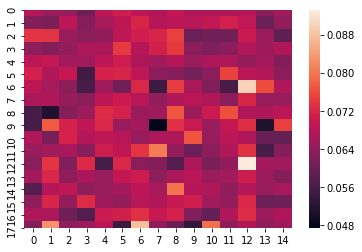

In [200]:
# not a clear interpretation by genre
import seaborn as sns
sns.heatmap(x.iloc[:,1:])

# Grid-search for ideal n_factors 

In [216]:
from surprise.model_selection import GridSearchCV
from surprise import Reader, Dataset
from surprise import NMF

In [217]:
reader = Reader(rating_scale=(1.0,5.0))
data = Dataset.load_from_df(ratings, reader)

In [218]:
param_grid = {'biased':[False], 'n_factors': [*list(range(3,21)), 25, 30, 35, *list(range(40,101,10)), *list(range(150, 1001, 50))]}
gs = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=3, refit=False, return_train_measures=True)

In [219]:
gs.fit(data)

In [221]:
gs.cv_results

{'split0_test_rmse': array([1.19558159, 1.15930491, 1.1248596 , 1.10246247, 1.08086065,
        1.08199139, 1.07156126, 1.04895736, 1.05217367, 1.04647692,
        1.04137978, 1.03814106, 1.04143392, 1.03600163, 1.03980171,
        1.03653519, 1.02720524, 1.03323387, 1.03942967, 1.04249432,
        1.04280827, 1.05132816, 1.05915781, 1.06877642, 1.07906034,
        1.08668215, 1.09218104, 1.10471089, 1.12947612, 1.14674392,
        1.16503965, 1.1749152 , 1.18396671, 1.19064686, 1.19623427,
        1.20097664, 1.20475314, 1.20974234, 1.21346494, 1.21688437,
        1.21925518, 1.22045923, 1.22271246, 1.22462134, 1.2267542 ,
        1.22851126]),
 'split0_train_rmse': array([0.98681331, 0.91204758, 0.83729795, 0.77322093, 0.73419449,
        0.7050166 , 0.67229372, 0.63981376, 0.62413193, 0.60451168,
        0.58887713, 0.57989708, 0.57478461, 0.56311613, 0.55174306,
        0.54838101, 0.54428418, 0.54410209, 0.53879872, 0.54881759,
        0.5565438 , 0.57753108, 0.60371594, 0.6302105

In [228]:
n_factors = [y['n_factors'] for y in gs.cv_results['params']]

In [237]:
gs_results = pd.DataFrame({'n_factors': n_factors, 'mean_fit_time': gs.cv_results['mean_fit_time'], 'mean_train_rmse': gs.cv_results['mean_train_rmse'], 
              'std_train_rmse': gs.cv_results['std_train_rmse'], 'mean_test_rmse': gs.cv_results['mean_test_rmse'], 'std_test_rmse': gs.cv_results['std_test_rmse']})

In [238]:
gs_results.head()

,n_factors,mean_fit_time,mean_train_rmse,std_train_rmse,mean_test_rmse,std_test_rmse
0,3,0.927069,0.993605,0.005104,1.191889,0.002634
1,4,0.944181,0.909252,0.003760,1.149331,0.007624
2,5,0.981975,0.838609,0.002878,1.120864,0.002865
3,6,1.038484,0.782365,0.006486,1.097724,0.003989
4,7,1.047860,0.737117,0.002695,1.077943,0.002146


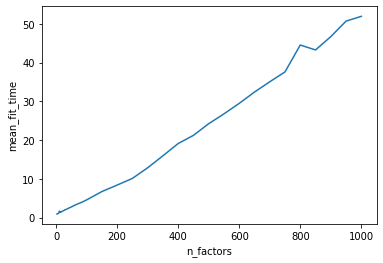

In [254]:
sns.lineplot(x="n_factors", y="mean_fit_time", data=gs_results)

In [241]:
dfs = [gs_results[['n_factors', 'mean_train_rmse', 'std_train_rmse']].copy(),
 gs_results[['n_factors', 'mean_test_rmse', 'std_test_rmse']].copy()]

In [242]:
for df in dfs:
    df.columns = ['n_factors', 'mean_rmse', 'stdev_rmse']
dfs[0]['dataset'] = 'train'
dfs[1]['dataset'] = 'test'
gs_plot = pd.concat(dfs, ignore_index=True)

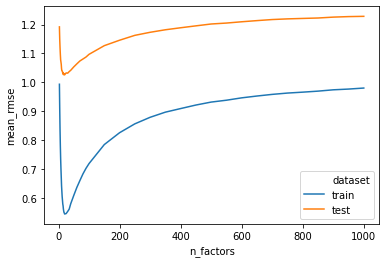

In [249]:
# looks like the 
sns.lineplot(x="n_factors", y="mean_rmse", hue='dataset', data=gs_plot)

In [253]:
# It looks like the best n_factors = 20, but its mean test RMSE = 1.026, which is not so different from
# the test RMSE for n_factors = 15 (1.034)
gs_results.sort_values(by=['mean_test_rmse'], ascending=True)

,n_factors,mean_fit_time,mean_train_rmse,std_train_rmse,mean_test_rmse,std_test_rmse
17,20,1.655417,0.545185,0.003620,1.026032,0.010234
16,19,1.593746,0.548732,0.003880,1.026241,0.006309
13,16,1.496797,0.562677,0.000386,1.026841,0.007506
15,18,1.513731,0.550602,0.001572,1.029255,0.007488
11,14,1.401103,0.579911,0.000496,1.030907,0.005347
14,17,1.494415,0.555802,0.003138,1.030984,0.007703
19,30,2.056358,0.553910,0.004543,1.031848,0.007807
18,25,1.789501,0.546675,0.005849,1.032793,0.006204
12,15,1.391511,0.573545,0.001182,1.033694,0.006929
10,13,1.534069,0.592983,0.002928,1.037140,0.003735
